In [1]:
from accelerate import data_loader
from torchvision import datasets
import tqdm
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from unet import Unet
from diffusion_conditioned import DiffusionConditioned
from channel_engineering import rgb_to_lab, normalize_lab, unnormalize_lab, lab_to_rgb
from model_utils import ConcatModel
from colorization_module import ColorizationModule

In [2]:
# Initialize diffusion process and model
timesteps = 1000
#t_reconst=200
num_epochs = 5
device = torch.device("cuda")


In [3]:
model = ConcatModel(Unet(channels=128, out_channels=2)).to(device)
model.load_state_dict(torch.load('model_no_bias.pth'))
diffusion = DiffusionConditioned(model, timesteps=timesteps, device=device, beta_start=1e-4, beta_end=2e-2)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.CenterCrop(128),  # Crop to the central 128x128 region
    #transforms.Resize((128, 128)),  # Resize to 256x256
])
coloring = ColorizationModule(diffusion)




/tmp/ipykernel_138314/657429967.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_no_bias.pth'))


# CelebA tests

In [4]:
def numpized(torch_tensor):
    return torch_tensor.permute(1,2,0).detach().cpu().numpy()

In [5]:
train_dataset = datasets.CelebA(root="data", transform=transform, download=True)
nb_data = 2
data = torch.zeros((nb_data, 3, 128,128))
for k,elt in enumerate(train_dataset):
    data[k] = elt[0]
    if k==nb_data-1:
        break


Files already downloaded and verified


/tmp/ipykernel_132368/2625946742.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


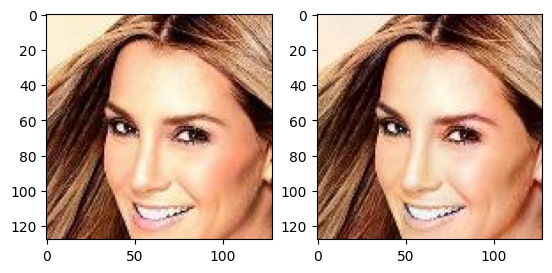

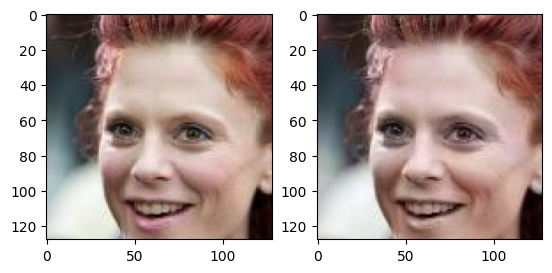

In [24]:

img_rgb,infos = coloring(data.to(device), T=100)for img_base,img_generated in zip(data,img_rgb):
    fig,axes = plt.subplots(1,2)
    axes[0].imshow(np.clip(numpized(img_base), 0, 1))
    axes[1].imshow(np.clip(numpized(img_generated), 0, 1))
    fig.show()

In [44]:
T_to_use = [0,100,200,300,400,500,600,700,800,900]
def generate_res(data_to_use, schedule_T):
    all_noised_img= []
    all_results = []
    
    for t in schedule_T:
        
        img_rgb,infos = coloring(data_to_use.to(device), T=t)
        if t==0:
            img_noised = data_to_use.to(device)
        else:
            img_noised = infos["img_noised"]
        all_noised_img.append(img_noised)
        all_results.append(img_rgb)
    return all_results, all_noised_img

results,noised = generate_res(data, T_to_use)

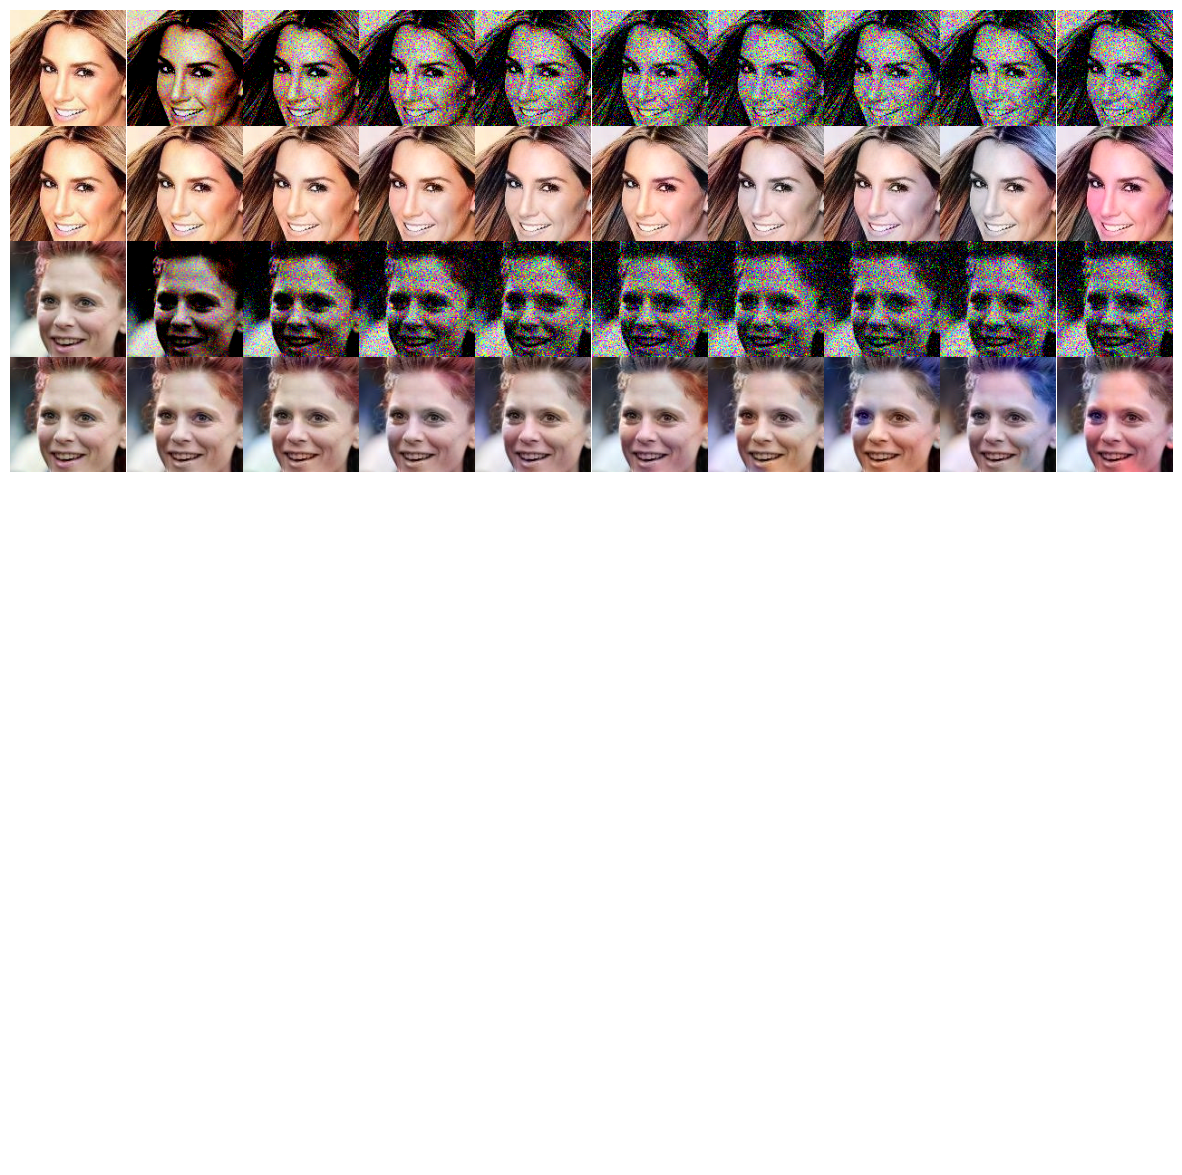

In [45]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15), gridspec_kw={'hspace': 0, 'wspace': 0})
for ax in axes.ravel():
    ax.axis("off")
    ax.set_aspect('auto')
for i in range(10):
    for j in range(2):
        axes[2*j][i].imshow(np.clip(numpized(noised[i][j]),0,1))
        axes[2*j+1][i].imshow(np.clip(numpized(results[i][j]),0,1))
        
plt.subplots_adjust(wspace=0, hspace=0)

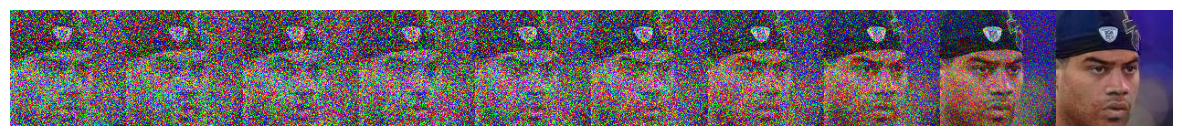

In [12]:
nb_data = 2
data = torch.zeros((nb_data, 3, 128,128))
for k,elt in enumerate(train_dataset):
    if k<=35:
        continue
    else:
        break
data = elt[0].unsqueeze(0)
img_rgb,infos = coloring(data.to(device), to_log=True)
T = [100* k for k in range(10)]
images = []
for t in reversed(T):
    images.append(numpized(infos["logs"][t][0]))

fig,axes = plt.subplots(1,len(images), figsize=(15,15))
for ax in axes.ravel():
    ax.axis("off")
    ax.set_aspect('auto')

for (ax,img) in zip(axes, images):
    ax.imshow(np.clip(img,0,1))
plt.subplots_adjust(wspace=0, hspace=0)


# Other tests

In [9]:
paths = ["./img/390px-Louis_Charles_Breguet.jpg", "./img/6161cc213ccb4_19-visite-dijon-descendants-gustave-eiffel-00-00-09-20.jpg", "./img/Victor-Hugo-Etienne-Carjat-1876-©BnF.jpg"]
all_img = list(map(lambda x : Image.open(x), paths))

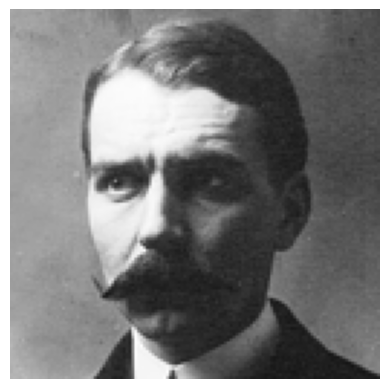

In [10]:
breguet_transformed = transform(all_img[0].crop((200-128,200-128,200+128,200+128)).resize((128,128)))
breguet_transformed = torch.concatenate([breguet_transformed,breguet_transformed,breguet_transformed], dim=0)
plt.imshow(numpized(breguet_transformed))
plt.axis("off")
plt.show()

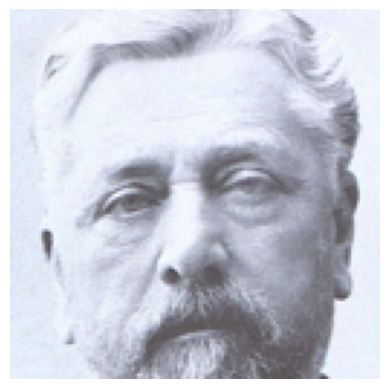

In [11]:
eiffel_transformed = transform(all_img[1].crop((950-300,400-300,950+300,400+300)).resize((128,128)))
plt.imshow(numpized(eiffel_transformed))
plt.axis("off")
plt.show()

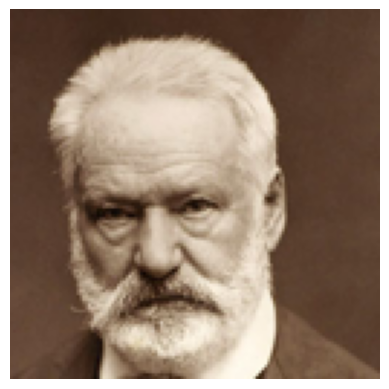

In [12]:
hugo_transformed = transform(all_img[2].crop((350-128,200-128,350+128,200+128)).resize((128,128)))
plt.imshow(numpized(hugo_transformed))
plt.axis("off")
plt.show()

In [13]:

def generate_multiple(img, n=10):

    for k in range(n):
        print(k)
        img_produced,_ = coloring(img.unsqueeze(0).to(device))
        plt.axis("off")
        plt.imshow(numpized(img_produced[0]))
        plt.show()
    

0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013950201..1.1888235].


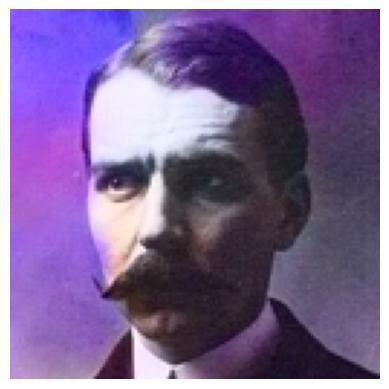

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019414635..1.0697845].


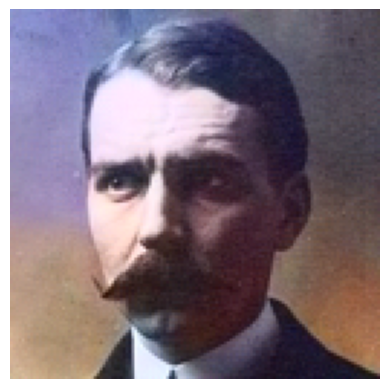

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.016362436..1.0491797].


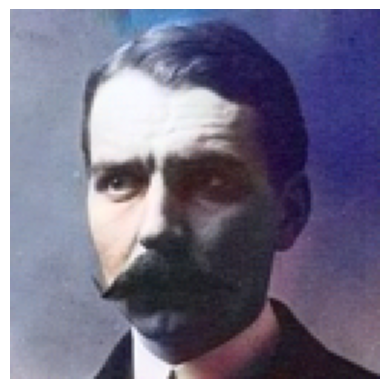

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0035806461..1.0910444].


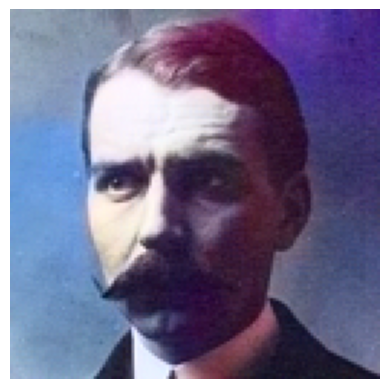

4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.046814956..1.1299286].


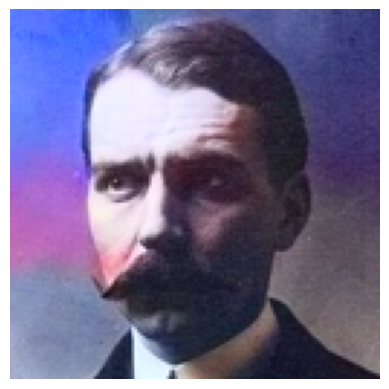

5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.040656086..1.0441204].


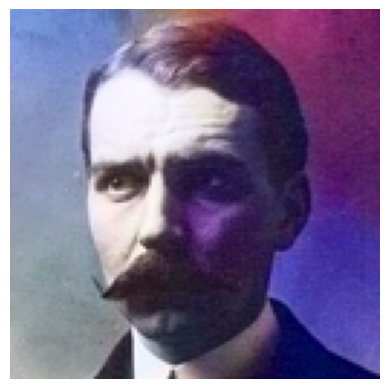

6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.035073895..1.2297888].


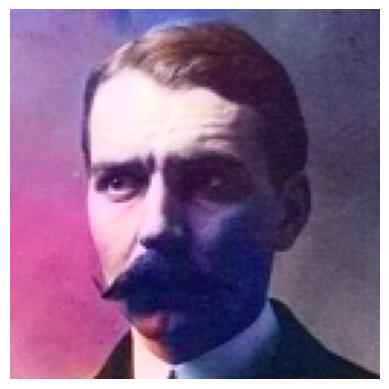

7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041365527..1.0533762].


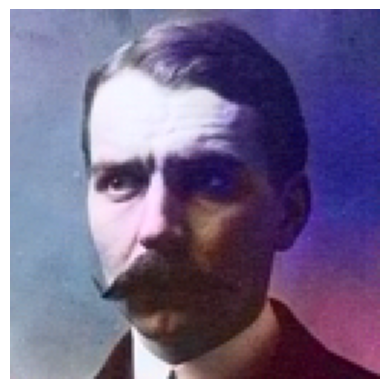

8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.023754505..1.0487216].


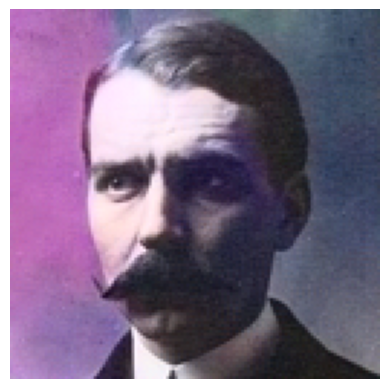

9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010111032..1.0621921].


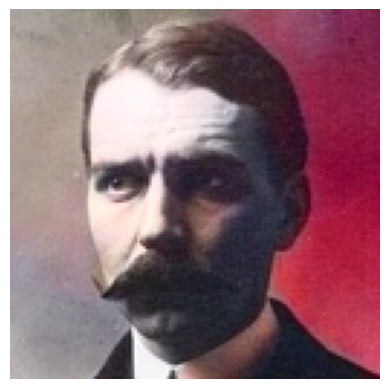

10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043648858..1.0736402].


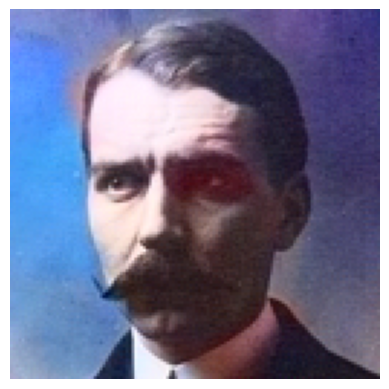

11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.036014244..1.0993936].


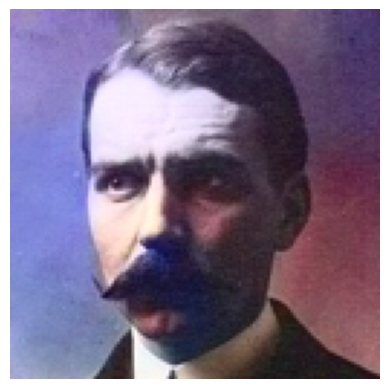

12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.016233144..1.1070933].


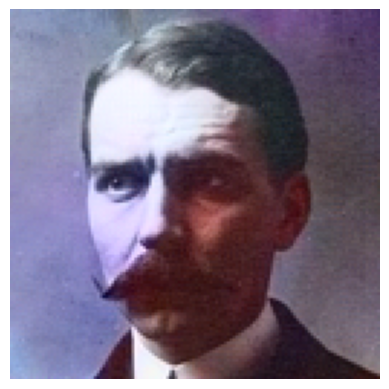

13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14276394..1.1499563].


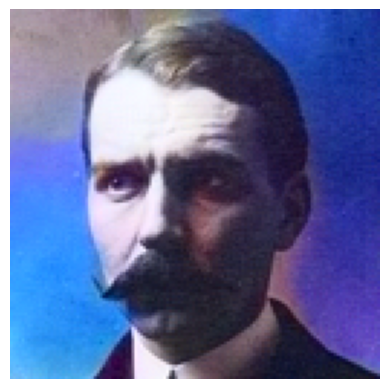

14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017421242..1.0928733].


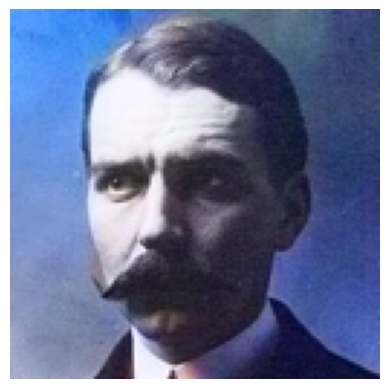

15


KeyboardInterrupt: 

In [14]:
generate_multiple(breguet_transformed, n=50)